In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from mlflow_utils import log_mlflow

In [2]:
index = 'SNP'
validation_days = 20
experiment = 'indices'
run_name = 'initial_assessment'
artifacts_dir = '../artifacts'

In [3]:
run_params = {
    'experiment': experiment,
    'iteration': run_name,
    'index': index,
    'artifacts_dir': artifacts_dir,
}

## Import data

In [4]:
idf = pd.read_csv('../data/{}.csv'.format(index))

## Data prepration

In [5]:
idf.columns = [col.lower().replace(' ', '_') for col in idf.columns]
idf.sort_values(by='date', ascending=True, inplace=True)

In [6]:
idf.head()

,date,open,high,low,close,adj_close,volume
0,2000-10-18,15.865385,16.057692,15.865385,15.961538,6.223459,15145260.0
1,2000-10-19,15.384615,15.576923,14.807692,15.528846,6.054749,1434680.0
2,2000-10-20,15.480769,15.673077,15.384615,15.384615,5.998515,263120.0
3,2000-10-23,15.096154,15.096154,14.278846,14.903846,5.811061,615940.0
4,2000-10-24,14.615385,14.759615,14.326923,14.423077,5.623607,674310.0


## Create features

In [7]:
df = idf[['date', 'open', 'adj_close']].copy()

In [8]:
df['prev'] = df['adj_close'].shift(1)
df['sma2'] = df['prev'].rolling(window=2).mean()
df['sma5'] = df['prev'].rolling(window=5).mean()
df['sma10'] = df['prev'].rolling(window=10).mean()
df['sma20'] = df['prev'].rolling(window=20).mean()
df['ema12'] = df['prev'].ewm(span=12, min_periods=12, adjust=False).mean()
df['ema26'] = df['prev'].ewm(span=26, min_periods=26, adjust=False).mean()

In [9]:
def difference(prev_price, moving_average):
    return (prev_price - moving_average) / prev_price
for col in ['sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']:
    df['{}_diff'.format(col)] = difference(df['prev'], df[col])

In [10]:
df.dropna(inplace=True)
df.shape

(5106, 16)

In [11]:
df.drop(columns=['date', 'open'], inplace=True)

## Create label

In [12]:
df['label'] = (df['adj_close'] > df['prev']).astype(int)

## Create training data

In [13]:
train = df.iloc[:-validation_days].copy()
val = df.iloc[-validation_days:].copy()

## Visualization

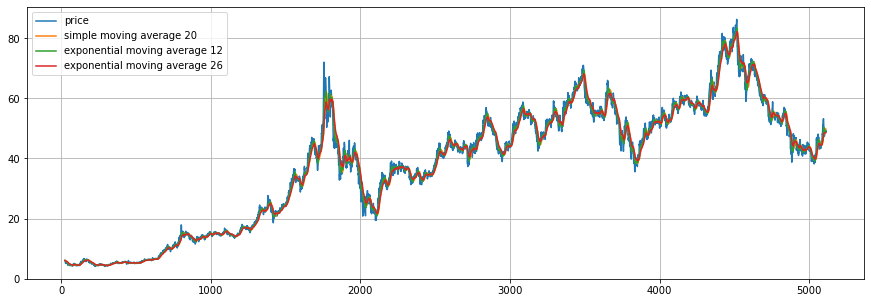

In [14]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(train['adj_close'], label='price')
plt.plot(train['sma20'], label='simple moving average 20')
plt.plot(train['ema12'], label='exponential moving average 12')
plt.plot(train['ema26'], label='exponential moving average 26')
plt.legend()

## Feature transformations

In [15]:
scaler = StandardScaler()
COLS_TO_SCALE = ['prev', 'sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']
scaler.fit(train[COLS_TO_SCALE])
train[COLS_TO_SCALE] = scaler.transform(train[COLS_TO_SCALE])
val[COLS_TO_SCALE] = scaler.transform(val[COLS_TO_SCALE])

## Linear regression coefficients

In [16]:
x_variables = '+'.join(list(train.columns[1:-1]))
results = smf.ols('adj_close ~ {}'.format(x_variables), data=train).fit()

In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              adj_close   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.933e+05
Date:                Wed, 17 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:45:50   Log-Likelihood:                -6690.5
No. Observations:                5086   AIC:                         1.341e+04
Df Residuals:                    5072   BIC:                         1.350e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.1036      0.013   2983.241      0.000      38.079      38.129
prev          16.5286      1.239     13.341      0.000      14.100      18.958
sma2           6.8899      2.006      3.434      0.001       2.957      10.823
sma5           2.3507      3.285      0.715      0.474      -4.090       8.792
sma10          8.1097      4.808      1.687      0.092      -1.316      17.535
sma20          3.1759      3.481      0.912      0.362      -3.648      10.000
ema12        -20.6353     13.541     -1.524      0.128     -47.181       5.910
ema26          3.6647      1.735      2.112      0.035       0.263       7.066
sma2_diff      5.2861      3.725      1.419      0.156      -2.017      12.589
sma5_diff      6.4017      6.188      1.035      0.301      -5.729      18.532
sma10_diff    11.3147      9.061      1.249      0.212      -6.450      29.079
sma20_diff     7.4214      6.606      1.123      0.261      -5.529      20.372
ema12_diff   -35.6538     25.458     -1.401      0.161     -85.562      14.254
ema26_diff     5.0114      3.281      1.527      0.127      -1.421      11.444
==============================================================================
Omnibus:                      870.408   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14462.618
Skew:                           0.298   Prob(JB):                         0.00
Kurtosis:                      11.240   Cond. No.                     6.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Train basic models

In [18]:
y_train = train['label'].values
X_train = train.drop(columns='label').values
y_val = val['label'].values
X_val = val.drop(columns='label').values

### Logistic Regression

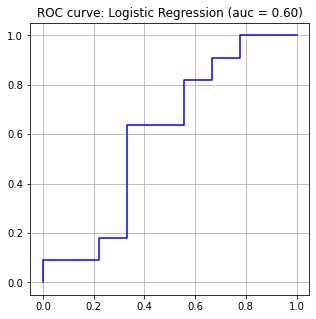

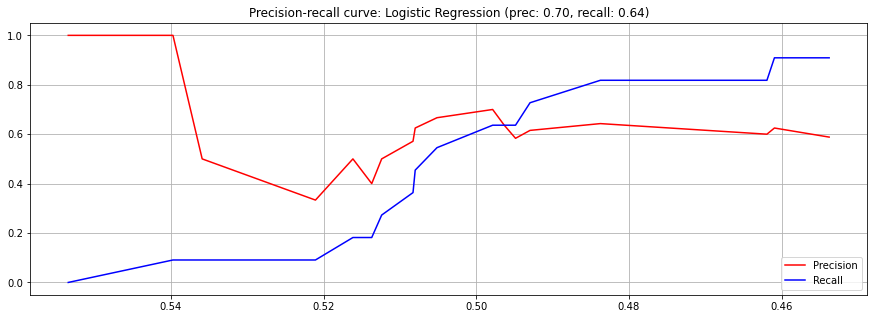

In [19]:
model_name = 'Logistic Regression'
model = LogisticRegression(fit_intercept=False).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

### K-neighbours

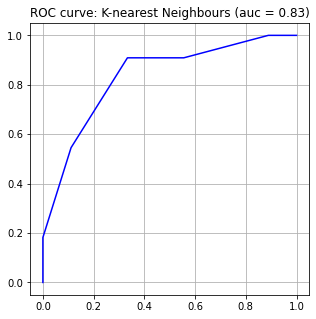

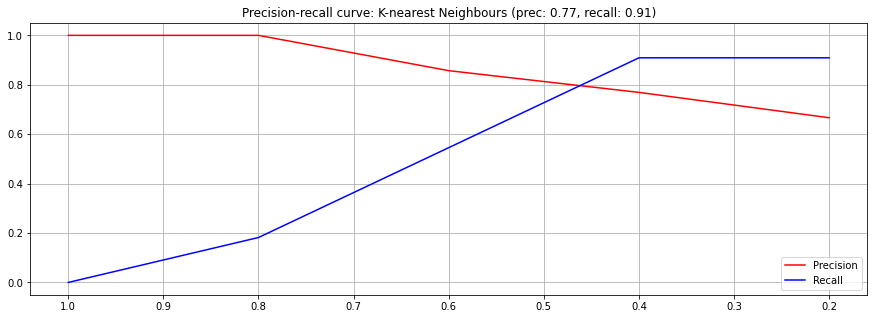

In [20]:
model_name = 'K-nearest Neighbours'
model = KNeighborsClassifier(5).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)